<p style="text-align:center">
    <a href="https://nbviewer.jupyter.org/github/twMr7/PyTorch-Deep-Learning/blob/master/03-CNN_Introduction_with_Lightning.ipynb">
        Open In Jupyter nbviewer
        <img style="float: center;" src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" width="120" />
    </a>
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/PyTorch-Deep-Learning/blob/master/03-CNN_Introduction_with_Lightning.ipynb)

# 3. CNN Introduction with Lightning

[**Convolutional Neural Network（CNN）**](https://en.wikipedia.org/wiki/Convolutional_neural_network) 與一般 DNN 的差異，主要就在於隱藏層使用捲積（convolution）運算。 在影像或數位訊號處理的領域，空間濾波（spatial filtering）及頻域濾波（frequency domain filtering）的基本運算就是捲積。 首先對捲積的操作有個基礎認識，對學習 CNN 是有幫助的。

+ [**3.1 Convolution**](#conv-operation)
    - [*一維捲積範例*](#conv-1d)
    - [*二維捲積範例*](#conv-2d)
    - [*Why does CNN apply Cross-Correlation instead of Convolution?*](#why-corr)
+ [**3.2 CNN 簡介與基本架構**](#cnn-intro)
    - [*典型 CNN 架構*](#cnn-architecture)
    - [*Convolution Layer*](#conv-layer)
    - [*Pooling Layer*](#pooling-layer)
+ [**3.3 動手做 － 加了點現代手法的 LeNet**](#lenet-lightning)
    - [*MNIST 手寫資料集*](#mnist-dataset)
    - [*使用 LightningModule 讓模型建構與訓練更有系統的組織*](#lightning-module)
    - [*Multi-Class Logistic Regression*](#multiclass-logireg)
    - [*LightningDataModule and Bolts*](#lightning-bolts)
    - [*Tensorboard Logger*](#tensorboard-logger)
    - [*Lightning Trainer*](#lightning-trainer)
+ [**參考資料**](#references)


In [1]:
# 輔助圖片顯示及嵌入 notebook
from IPython.display import Image

<a id="conv-operation"></a>

## 3.1 Convolution

Let $f(t)$ and $g(t)$ be piecewise continuous on $(-\infty, \infty)$. The convolution of $f(t)$ and $g(t)$, denoted $f \ast g$, is defined as the integral of the product of the two functions after one is reversed and shifted.

$$
    (f \ast g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t - \tau) \; \mathrm{d}\tau \tag{1}
$$

#### Properties:

For function $f(t)$, $g(t)$, and $h(t)$:
+ $f \ast g = g \ast f$
+ $(f \ast g) \ast h = f \ast (g \ast h)$
+ $f \ast (a g + b h) = a (f \ast g) + b (f \ast h),\; \forall{a, b} \in \mathbb{R}$ 

#### Discrete Convolution

$$
    (f \ast g)[n] = \sum_{k\, =\, -\infty}^{\infty} f[k] g[n-k] \tag{2}
$$

在應用領域常會看到這樣的術語，$f$ 與 $g$ 一個是輸入訊號的話，另外一個就是濾波器，濾波器的英文會看到使用 ***filter*** 或 ***kernel*** 來稱呼。

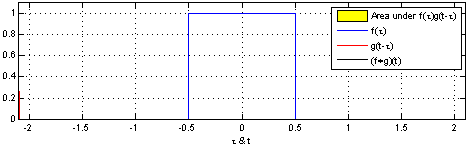

In [2]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif', embed=True, width=480)

In [3]:
import numpy as np
from scipy.ndimage import correlate, convolve

import torch
import torch.nn.functional as F

#### 相關套件函數說明文件：

+ `scipy.ndimage.`[**`convolve`**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html) - 捲積，適用多維度。
+ `scipy.ndimage.`[**`correlate`**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.correlate.html) - 互相關，適用多維度。
+ `torch.nn.functional.`[**`conv1d`**](https://pytorch.org/docs/stable/nn.functional.html#conv1d) - 一維捲積函數。
+ `torch.nn.functional.`[**`conv2d`**](https://pytorch.org/docs/stable/nn.functional.html#conv2d) - 二維捲積函數。
+ `torch.nn.`[**`Conv1d`**](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) - 一維捲積類別。
+ `torch.nn.`[**`Conv2d`**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - 二維捲積類別。


---

<a id="conv-1d"></a>

### § 一維捲積範例


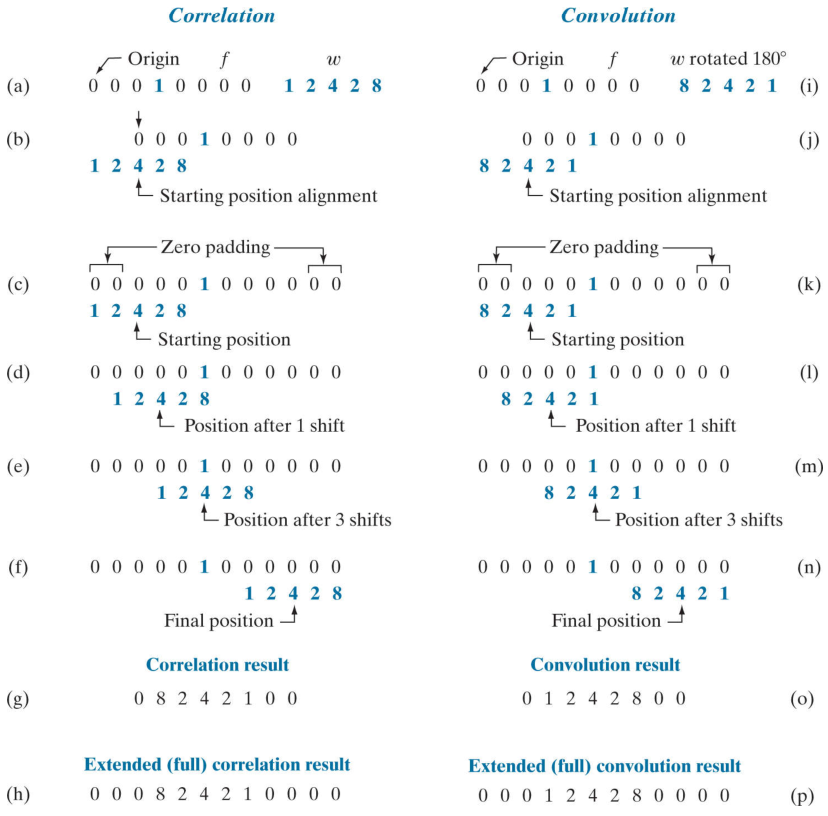

In [4]:
Image(filename='images/conv_corr_example1.png', width=800)

In [5]:
f = np.array([0, 0, 0, 1, 0, 0, 0, 0])
print(f'單位脈衝 f = {f}')

w = np.array([1, 2, 3, 4, 5])
print(f'濾波器 w = {w}')

單位脈衝 f = [0 0 0 1 0 0 0 0]
濾波器 w = [1 2 3 4 5]


In [6]:
# 用 scipy 的 correlation 操作 cross-correlation
print(f'f ⋆ w = {correlate(f, w)}')

f ⋆ w = [0 5 4 3 2 1 0 0]


In [7]:
# 用 scipy 的 convolve 操作 convolution
print(f'f ∗ w = {convolve(f, w)}')

f ∗ w = [0 1 2 3 4 5 0 0]


#### 使用 torch 的 `conv1d()` 函數


In [8]:
# 單位脈衝形式的輸入訊號 x tensor
xt = torch.from_numpy(f)
print(f'單位脈衝 xt = {xt}')

# 濾波器 w tensor
wt = torch.from_numpy(w)
print(f'濾波器 wt = {wt}')

單位脈衝 xt = tensor([0, 0, 0, 1, 0, 0, 0, 0], dtype=torch.int32)
濾波器 wt = tensor([1, 2, 3, 4, 5], dtype=torch.int32)


In [9]:
# 套用 torch 的一維捲積函數
F.conv1d(xt.view(1,1,-1), wt.view(1,1,-1), padding=2).squeeze()

# 為什麼這運算結果是 … Cross-Correlation？

tensor([0, 5, 4, 3, 2, 1, 0, 0], dtype=torch.int32)

In [10]:
# 先把 w 反轉後再套用 torch 的一維捲積函數
F.conv1d(xt.view(1,1,-1), wt.flip(0).view(1,1,-1), padding=2).squeeze()

# 為什麼這運算結果才是 Convolution？

tensor([0, 1, 2, 3, 4, 5, 0, 0], dtype=torch.int32)

---

<a id="conv-2d"></a>

### § 二維捲積範例


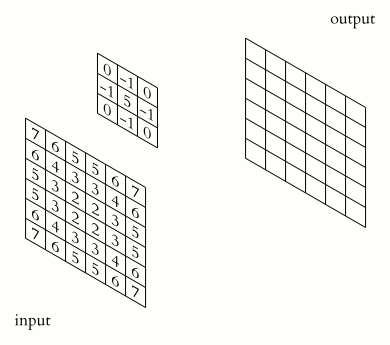

In [11]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif', embed=True, width=480)

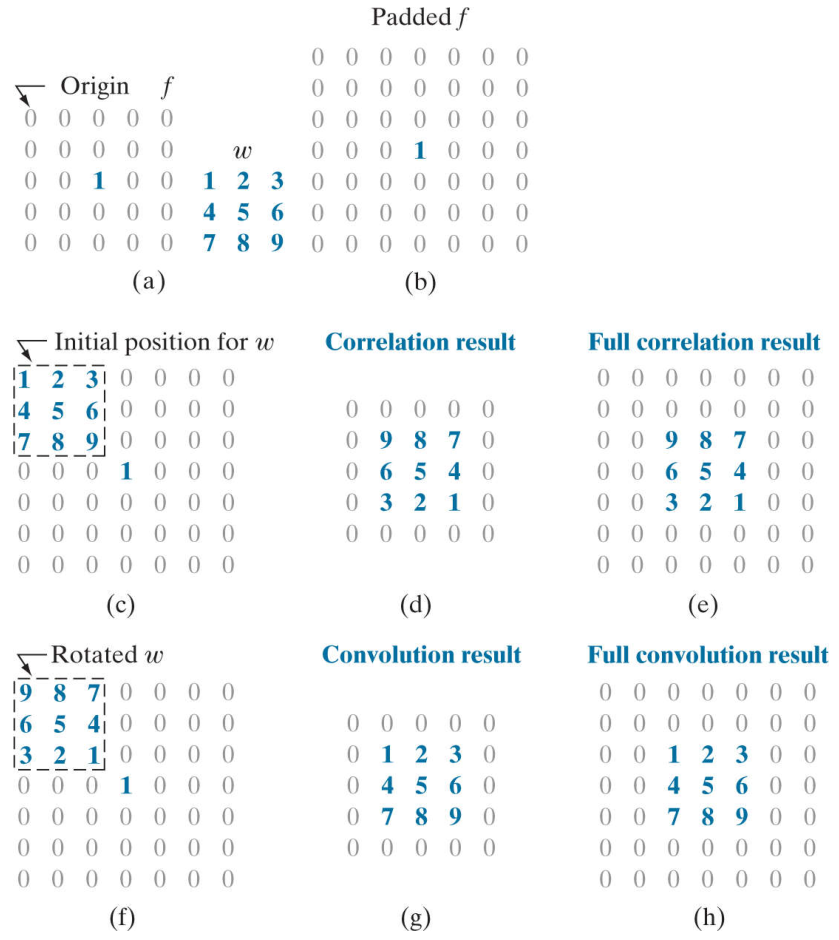

In [12]:
Image(filename='images/conv_corr_example2.png', width=800)

In [13]:
f2d = np.array([[0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0]])
print(f'二維單位脈衝 f2d =\n{f2d}\n')


w2d = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])
print(f'二維濾波器 w2d =\n{w2d}\n')

二維單位脈衝 f2d =
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

二維濾波器 w2d =
[[1 2 3]
 [4 5 6]
 [7 8 9]]



In [14]:
# 用 scipy 的二維 correlation 操作
print(f'f2d ⋆ w2d =\n{correlate(f2d, w2d)}\n')

f2d ⋆ w2d =
[[0 0 0 0 0]
 [0 9 8 7 0]
 [0 6 5 4 0]
 [0 3 2 1 0]
 [0 0 0 0 0]]



In [15]:
# 用 scipy 的二維 convolution 操作
print(f'f2d ∗ w2d =\n{convolve(f2d, w2d)}\n')

f2d ∗ w2d =
[[0 0 0 0 0]
 [0 1 2 3 0]
 [0 4 5 6 0]
 [0 7 8 9 0]
 [0 0 0 0 0]]



#### 使用 torch 的 `conv2d()` 函數


In [16]:
# 單位脈衝形式的二維輸入訊號 x tensor
xt2d = torch.from_numpy(f2d)
print(f'單位脈衝 xt2d =\n{xt2d}\n')

# 濾波器 w tensor
wt2d = torch.from_numpy(w2d)
print(f'濾波器 wt2d =\n{wt2d}\n')

單位脈衝 xt2d =
tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

濾波器 wt2d =
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], dtype=torch.int32)



In [17]:
wt2d.flip([0,1])

tensor([[9, 8, 7],
        [6, 5, 4],
        [3, 2, 1]], dtype=torch.int32)

In [18]:
# 套用 torch 的一維捲積函數
F.conv2d(xt2d.view(1,1,5,5), wt2d.view(1,1,3,3), padding=1).squeeze()

# 為什麼這運算結果是 … Cross-Correlation？

tensor([[0, 0, 0, 0, 0],
        [0, 9, 8, 7, 0],
        [0, 6, 5, 4, 0],
        [0, 3, 2, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [19]:
# 先把 w 翻轉後再套用 torch 的一維捲積函數
F.conv2d(xt2d.view(1,1,5,5), wt2d.flip([0,1]).view(1,1,3,3), padding=1).squeeze()

# 為什麼這運算結果才是 Convolution？

tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 3, 0],
        [0, 4, 5, 6, 0],
        [0, 7, 8, 9, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

---

<a id="why-corr"></a>

### § Why does CNN apply Cross-Correlation instead of Convolution?

還沒正式開始介紹 CNN，不過從前面套用 torch `conv1d` 和 `conv2d` 的結果，已經可以觀察到這個令人匪夷所思的疑問。 為什麼捲積神經網路的捲積層是使用 cross-correlation 的操作？

+ 其實在影像和訊號處理的應用領域，**許多濾波器是各維度都對稱的設計**，翻轉與否不影響，cross-correlation 與 convolution 的操作結果是一樣的。
+ 比較關鍵且普遍被認同的觀點是，**濾波器在 CNN 就是要經過訓練學習來的參數**，翻轉與否一樣不影響結果，濾波器會隨著神經網路所套用的運算而調整學習參數。 


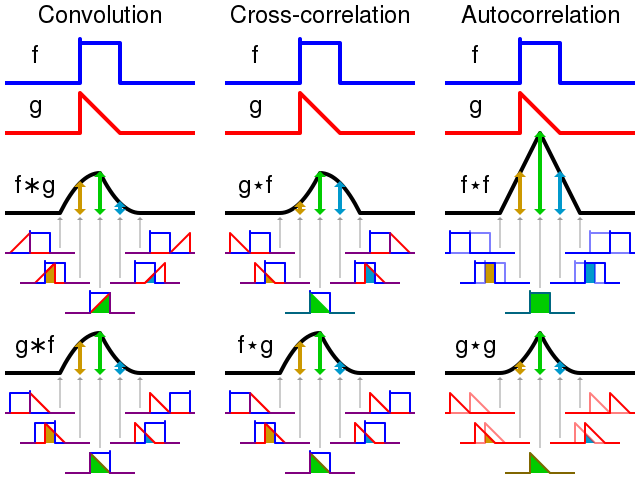

In [20]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Comparison_convolution_correlation.svg/640px-Comparison_convolution_correlation.svg.png', embed=True, width=640)

<a id="cnn-intro"></a>

## 3.2 CNN 簡介與基本架構

針對影像或訊號的數據處理，使用 CNN 會比 MLP 更適合，主要有幾個原因：

1. 影像的輸入資料通常很大，使用 MLP 全連結所需要學習的參數量就很大。 CNN 要學習的是濾波器，kernel尺寸通常只是 $3 \times 3$ 或 $5 \times 5$ 的大小，參數量相對小很多。
2. MLP所學習的參數，只會對固定位置的相同輸入特徵激發相同反應。 捲積的操作可以想成是某種形式的 *template matching*，輸入特徵出現在影像的不同位置都可以激發相同反應，也就是說 CNN 有 ***translation invariant*** 的特性。 
3. MLP所學習的參數，無法適用於會有不同輸入大小的影像。 CNN 具備 *translation invariant* 的特性，使得不同尺寸的輸入影像都可以處理。

最早開始使用捲積層的類神經網路是 **Neocognitron** (1980)，發展到 1989 年 [Yann LeCun](https://en.wikipedia.org/wiki/Yann_LeCun) 開始採用 backpropagation 讓 convolution 濾波器遮罩的係數可以自動學習，奠立了現代電腦視覺的基礎手法。 1998 年 LeCun 與 [Yoshua Bengio](https://en.wikipedia.org/wiki/Yoshua_Bengio) 團隊發表了開創性架構的 **LeNet**，這個技術並實際被一些銀行用來辨識支票上的手寫數字。 當時的 LeNet 已經具備可以處理更高解析度以及建立更深層網路的雛型了，只是受限於當時電腦系統的運算資源。

2004年開始有研究使用 GPU 運算加速 CNN 網路的學習，並且利用這個優勢贏了幾個影像辨識的競賽。 但直到 [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton) 團隊的 Alex Krizhevsky 在 2012 年贏得 ImageNet 競賽，這個 **AlexNet** 的架構也是利用 GPU 的優勢訓練了深層的 CNN 網路，在當時以相當大幅度的進展（錯誤率 $25\% \to 16\%$ ）贏得了各界的注意，也開始引起了全世界對深度學習的熱潮。


---

<a id="cnn-architecture"></a>

### § 典型 CNN 架構

經典 **LeNet** 結構的組合中，已經包含了大部分現代 CNN 網路架構的典型。 典型的 CNN 結構如下：

**【特徵學習機】**
+ **Convolution Layer** － 捲積層包含學習來的濾波器參數，主要的特徵擷取能力來源。
+ **Non-Linear Activation** － 捲積是線性的操作，所以會經過非線性的 activation 函數（如：ReLU）後輸出至下一層。
+ **Pooling Layer** － 經常接在捲積層之後用來將特徵降低取樣，不包含可學習的參數，所以通常不是被看成獨立的一個隱藏層，而是延續捲積同一層的操作。

會重複多次的 *Conv-ReLu-Pool* 層，而且通常設計成輸出的特徵圖（feature-map）空間尺寸（H×W）越來越小，但濾波器可以呈現多樣性的深度（通道數，Channel）越來越深。

**【回歸、分類器】**
+ **Flatten** － 在進入全連接層之前，多維度多通道的特徵需要先經過平坦化的操作。
+ **Fully Connected Layer** － 在經過數層的捲積特徵學習之後，特徵會輸入全連接層組成的典型 MLP，最後輸出回歸的連續值或是分類的機率。


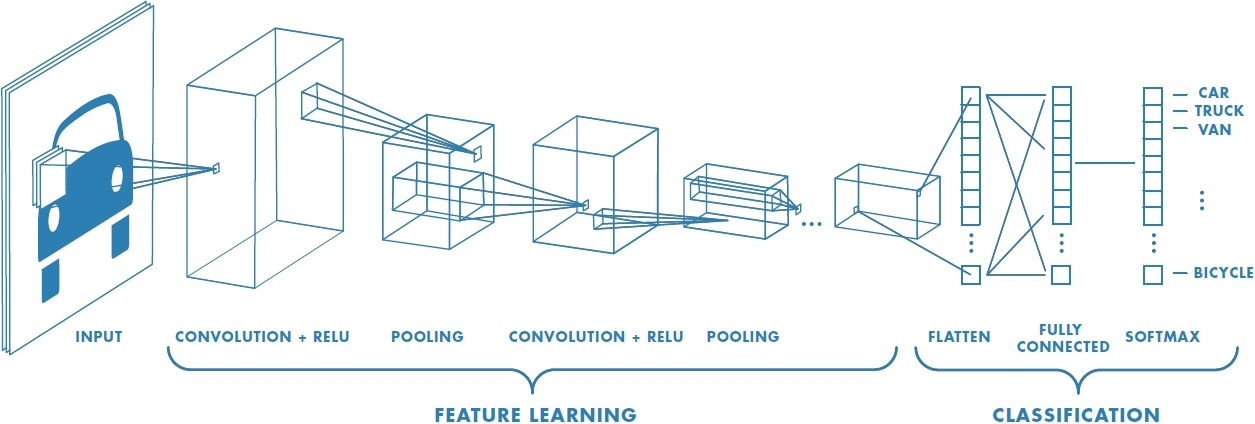

In [21]:
# Adapted from https://blog.floydhub.com/building-your-first-convnet/
Image(filename='images/common_cnn_architecture.jpg', width=800)

---

<a id="conv-layer"></a>

### § Convolution Layer

以處理多通道（如：RGB）影像的二維捲積層為例，符號表示如下:

- 輸出入影像的長×寬×深表示為 $\mathsf{H} \times \mathsf{W} \times \mathsf{C}$。（註：為了與 PyTorch 文件一致，這裡使用 $\mathsf{C}$ 代表通道深度的維度大小）
- $f$: filter，濾波器大小，通常是長寬相等的正方形。
- $s$: stride，濾波操作時，尋訪像素的移動間隔。
- $p$: padding，邊緣填充大小。若 $p = 2$，則 $\mathsf{H} = \mathsf{H} + 2, \; \mathsf{W} = \mathsf{W} +2$。

一般而言，前一層的輸出是後面一層的輸入，第 $\ell$ 層的輸入大小以上標表示表示為 $\mathsf{H}^{\ell - 1} \times \mathsf{W}^{\ell - 1} \times \mathsf{C}^{\ell - 1}$ （如圖例的 $6 \times 6 \times 3$），若第 $\ell$ 層使用的每一個濾波器大小為 $f^{\ell} \times f^{\ell} \times \mathsf{C}^{\ell - 1}$ （如圖例的 $3 \times 3 \times 3$），共使用了 $\mathsf{C}^{\ell}$ 個濾波器（如圖例的 $1$ 個），移動間隔 $s^{\ell}$（如圖例的間隔為 $1$），邊緣填充大小 $p^{\ell}$（如圖例的填充為 $0$），則第 $\ell$ 層 convolution 結果的輸出大小為 $\mathsf{H}^{\ell} \times \mathsf{W}^{\ell} \times \mathsf{C}^{\ell}$ （如圖例的 $4 \times 4 \times 1$），計算公式如下。

$$
\begin{align*}
    \mathsf{H}^{\ell} &= \lfloor \frac{\mathsf{H}^{\ell - 1} + 2p^{\ell} - f^{\ell}}{s^{\ell}} \rfloor + 1 \tag{3}\\
    \mathsf{W}^{\ell} &= \lfloor \frac{\mathsf{W}^{\ell - 1} + 2p^{\ell} - f^{\ell}}{s^{\ell}} \rfloor + 1 \tag{4}
\end{align*}
$$

CNN 通常不使用 padding，但若輸出要取得於原始輸入大小一致，則需設定邊緣填補大小為
$$
    \text{Same Padding:} \; p = \frac{1}{2} (f - 1) \tag{5}
$$

**捲積層的參數個數**

濾波器就是捲積層要學習的參數，第 $\ell$ 層的濾波器大小 $\mathrm{Weight} = \left( f^{\ell} \times f^{\ell} \times \mathsf{C}^{\ell - 1} \right)$，使用了 $\mathsf{C}^{\ell}$ 個濾波器， $\mathrm{bias} = \mathsf{C}^{\ell}$，所以第 $\ell$ 層的參數個數如式 $(6)$。

$$
    \text{Number of Parameters}^\ell = \left( f^{\ell} \times f^{\ell} \times \mathsf{C}^{\ell - 1} \right) \times \mathsf{C}^{\ell} + \mathsf{C}^{\ell} \tag{6}
$$


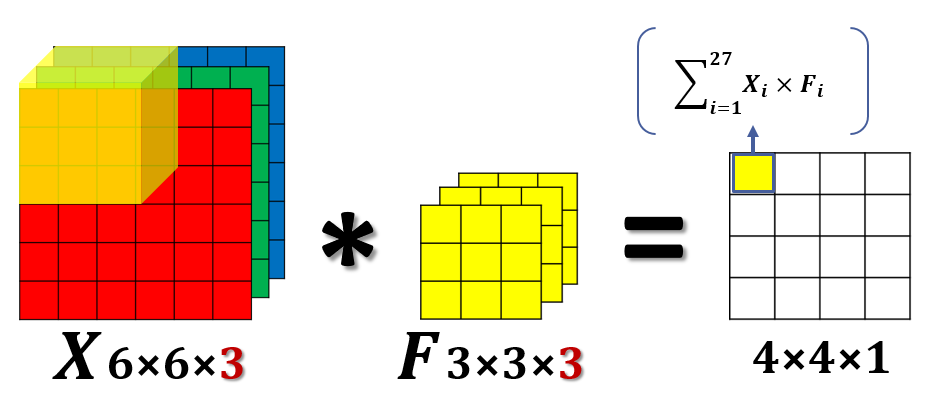

In [22]:
# 捲積層、濾波器、與輸出特徵圖大小
Image(filename='images/conv_layer_shape.png', width=600)

**Convolution 的各式變化**

請參閱連結 [**Convolution arithmetic**](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)。


---

<a id="pooling-layer"></a>

### § Pooling Layer

**Pooling 層** 是在 LeNet-5 架構就已經開始採用的手法，類似於 downsampling 的操作將特徵降低取樣，作法是針對每個通道用做一次類似捲積濾波的操作，但不是與 kernel 做內積的運算。 常見的種類有 **max pooling** 及 **average pooling**，分別就是在 kernel（如：$2 \times 2$）範圍中取出最大值及平均值。 由於 pooling 層單純只是降低取樣的操作，所以完全沒有需要學習的參數。

基本上，降低特徵取樣的操作有助於避免過度擬合的特徵擷取。 另外有人認為，捲積層有效地保留了影像中物件特徵的精確位置，但我們會希望模型學習到的特徵是不受空間位置改變而影響的（location invariant）；也就是說，當物件出現在影像中的不同位置時，模型學到的特徵仍然有效。 而經過 pooling 層處理後， "***the output neuron has the same response no matter where the input pattern occurs within its receptive field.*** "


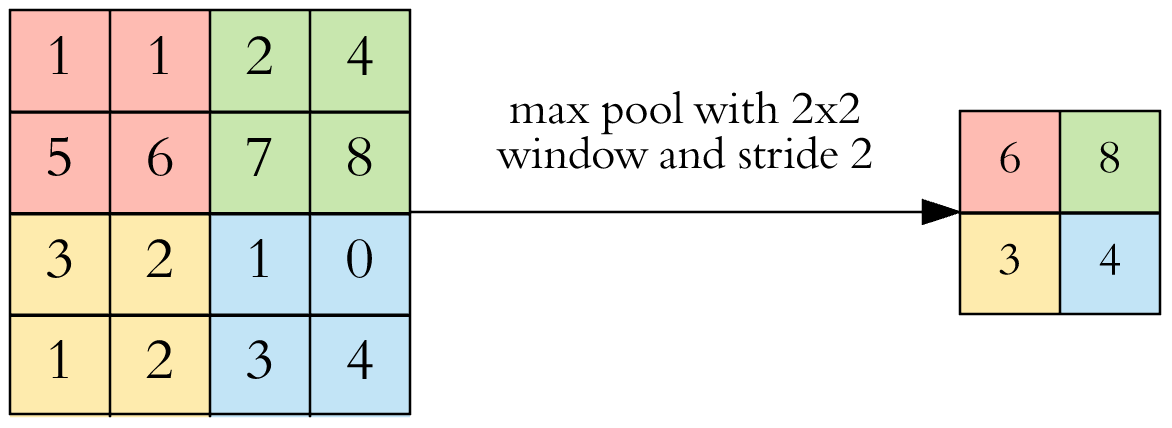

In [23]:
# max pooling 示意圖
Image(filename='images/max_pooling.png', width=600)

<a id="lenet-lightning"></a>

## 3.3 動手做 － 加了點現代手法的 LeNet

[**LeNet**](https://en.wikipedia.org/wiki/LeNet) 一般就是指 **LeNet-5**，主要是由七層組成的結構，原論文的架構如圖，設計細節請參閱 [[8]](#references)。 以下 LeNet-5 的說明及實作，會在維持原文主架構不變下，加入一些現代深度學習的偏好手法。

我們將 LeNet-5 當作五層，前兩層（**`conv1`**, **`conv2`**）為典型特徵擷取的捲積層＋降低取樣，後三層（**`fc1`**, **`fc2`**, **`fc3`**）為全連階的MLP分類器。

1. **`conv1`**： 輸入影像 $32 \times 32 \times 1$，捲積 kernel $5 \times 5 \times 1$，$s=1$，$p=0$。
    + *activation*： `relu`（註：原文為 scaled hyperbolic tangent）。
    + *pooling*： `max_pool`，kernel $2 \times 2$，$s=2$，$p=0$。
    +
2. **`conv2`**： 輸入 $14 \times 14 \times 6$，捲積 kernel $5 \times 5 \times 16$，$s=1$，$p=0$。
    + *activation*： `relu`（註：原文為 scaled hyperbolic tangent）。
    + *pooling*： `max_pool`，kernel $2 \times 2$，$s=2$，$p=0$。
    +
3. **`fc1`**： 輸入 $5 \times 5 \times 16 = 400$，神經元及輸出數 $120$。（註：原文C5為捲積層）。
    + *activation*： `relu`（註：原文為 scaled hyperbolic tangent）。
    +
4. **`fc2`**： 輸入 $120$，神經元及輸出數 $84$。
    + *activation*： `relu`（註：原文為 scaled hyperbolic tangent）。
    +
5. **`fc3`**： 輸入 $84$，神經元及最終輸出預測類別數 $10$。
    + *activation*： `softmax`（原文為 RBF distance）。


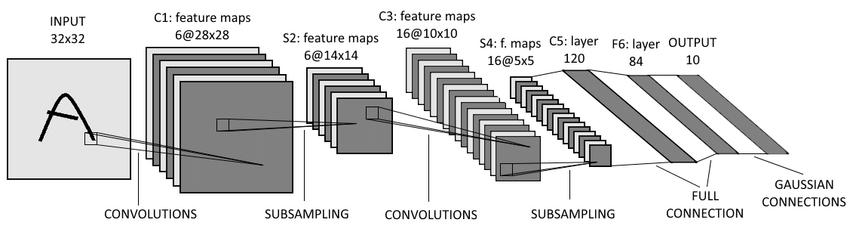

In [24]:
# LeNet 原論文架構圖
Image(filename='images/lenet_original.png', width=850)

<a id="mnist-dataset"></a>

### § MNIST 手寫資料集

PyTorch 套件裡的 [**torchvision**](https://pytorch.org/vision/) 提供了很多 [知名資料集](https://pytorch.org/vision/stable/datasets.html) 的存取類別，在實作 LeNet-5 之前，先認識一下要拿來訓練的 MNIST 手寫資料集。 主要是先了解一下，輸入的影像大小與 LeNet-5 原論文不同，所以在第一層 `conv1` 要做一點調整。


In [25]:
from torchvision import datasets

dstrain = datasets.MNIST('../data', train=True, download=True)
dstest = datasets.MNIST('../data', train=False)

print(f'Length of train set = {len(dstrain)}, test set = {len(dstest)}')

Length of train set = 60000, test set = 10000


Sample #0 is a 5, image type = <class 'PIL.Image.Image'>, size = (28, 28).
image value type uint8, min = 0, max = 255.


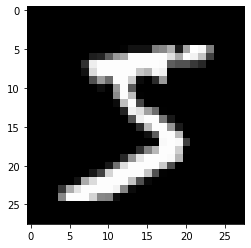

In [26]:
import matplotlib.pyplot as plt

index = 0
sample_x, sample_y = dstrain[index]

print(f'Sample #{index} is a {sample_y}, image type = {type(sample_x)}, size = {sample_x.size}.')

# convert PIL Image to Numpy ndarray
array_x = np.asarray(sample_x)
print(f'image value type {array_x.dtype}, min = {array_x.min()}, max = {array_x.max()}.')

plt.imshow(sample_x, cmap='gray')

<a id="lightning-module"></a>

### § 使用 LightningModule 讓模型建構與訓練更有系統的組織

[**PyTorch-Lightning**](https://pytorch-lightning.readthedocs.io/) 在 PyTorch 之上包裝了許多方便的功能，讓程式寫起來可以更簡潔，同時提供了許多可以自行調整功能的空間。 [**LightningModule**](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html) 就是一個功能擴充了的 `torch.nn.Module`，所以原本在建構式 `__init__()` 與前向傳導 `forward()` 該做的事一樣照做，其他擴充的功能在 `LightningModule` 類別裡都事先定義好方法的名字以及預設的執行方式了，這些固定名字就是該方法的介面，需要自訂修改的功能就直接重新實作來蓋過原本同名方法。

+ **`__init__()`**： 將所有模型中要訓練的參數層建構出來，並記錄在 `self` 成為物件屬性。
+ **`forward()`**： 只包含推論的部分，輸入資料的前向傳導運算，按順序經過所有層的函數操作。
+ **`configure_optimizers()`**： 在這個方法中指定 optimizer 方法，回傳該方法的物件就好，所有反向傳導參數更新由模組自動處理。
+ **`training_step()`**： 每次訓練一個 minibatch 的步驟，主要就是套用前向的推論，計算 loss 及其他評估 metrics，輸出日誌等。
+ **`validation_step()`**： 需要做的事與訓練步驟大致相同，不須要自己指定 `torch.no_grad()`。
+ **`test_step()`**： 需要做的事與驗證步驟大致相同。

PyTorch-Lightning 預設使用 [**tensorboard**](https://www.tensorflow.org/tensorboard) 記錄訓練過程的日誌，也是透過 `LightningModule` 類別提供的 `log()` 或 `log_dict()` 方法輸出就可以顯示在 tensorboard 中。


<a id="multiclass-logireg"></a>

### § Multi-Class Logistic Regression

在 Python 機器學習課程中，[Logistic Regression 的實作](https://github.com/twMr7/Python-Machine-Learning/blob/master/14-Building_A_Machine_Learning_Model_from_Scratch.ipynb) 章節中介紹了二元分類的 Logistic Regression 數學模型及透過 minimize **Negative Log Likelihood (NLL)** 來計算 **maximum likelihood estimation (MLE)**。 針對多類別的分類目標，我們還是可以採取相同的數學模型及手法，只是換成多類別的版本。

#### [**softmax**](https://en.wikipedia.org/wiki/Softmax_function)

假設共有 $k$ 個目標類別，最後一層 $k$ 個神經元計算輸出為 $z_{i}, i=1..k$，**softmax** 函數 $\sigma(z_{i})$ 為

$$
    \sigma(z_{i}) = \frac{e^{z_{i}}} {\sum_{i=1}^{k} e^{z_{i}}}
$$


**softmax** 用來將 $z_{i}$ 轉換成各類別出現的機率，轉換結果 $\sum_{i=1}^{k} \sigma(z_{i}) = 1$，即所有類別的機率總和為 1。 *Binary Logistic regression* 所用的 **sigmoid** 函數，其實就是 **softmax** 在類別個數 $k=2$ 時的特例。

#### [**Cross Entropy**](https://en.wikipedia.org/wiki/Cross_entropy)

假設共有$i=1..k$ 個目標類別，$y_i$ 是類別標籤（只有一個標籤是機率1，其餘為機率0），最後一層經過 **softmax** 後的輸出為各類別的機率 $\hat{y}_i,\; i=1..k$，則 **cross entropy** 函數 $H(y, \hat{y})$ 為

$$
    H(y, \hat{y}) = - \sum_{i=1}^{k} y_i log{\hat{y}_i}
$$


**PyTorch 的 Cross-Entropy 類別與函數**

+ `torch.nn.` [**`CrossEntropyLoss`**](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
+ `torch.nn.functional.` [**`cross_entropy()`**](https://pytorch.org/docs/stable/nn.functional.html#cross-entropy)
+ `torch.nn.functional.` [**`softmax()`**](https://pytorch.org/docs/stable/nn.functional.html#softmax)
+ `torch.nn.functional.` [**`log_softmax()`**](https://pytorch.org/docs/stable/nn.functional.html#log-softmax)
+ `torch.nn.functional.` [**`nll_loss()`**](https://pytorch.org/docs/stable/nn.functional.html#nll-loss)


為了最佳化速度及數值運算的穩定，PyTorch 套件將計算 softmax 及 NLL loss 的步驟整合成一個 Cross-Entropy 的函數與類別。 `softmax` 函數在套件裡還是有提供，但若要分兩步驟計算 cross-entropy loss 的話，PyTorch 提供的是 **`log_softmax()`** 及 **`nll_loss()`** 的組合呼叫。

有些常用的 metrics 在 PyTorch 套件裡沒有提供，例如： Accuracy、Sensitivity、ROC AUC ...等，這些在 [**`torchmetrics`**](https://torchmetrics.readthedocs.io/) 裡有提供，這是安裝 PyTorch-Lightning 時的相依套件。

+ `torchmetrics.functional.` [**`accuracy()`**](https://torchmetrics.readthedocs.io/en/latest/references/functional.html#accuracy-func)
+ `torchmetrics.functional.` [**`auroc()`**](https://torchmetrics.readthedocs.io/en/latest/references/functional.html#auroc-func)
+ `torchmetrics.functional.` [**`recall()`**](https://torchmetrics.readthedocs.io/en/latest/references/functional.html#recall-func)
+ `torchmetrics.functional.` [**`specificity()`**](https://torchmetrics.readthedocs.io/en/latest/references/functional.html#specificity-func)


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
import torchmetrics.functional as FM

class LeNet_Classifier(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.lr = 2e-3
        
        # Conv2d parameters: in_channels, out_channels, kernel_size
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Linear parameters: in_features, out_features
        self.fc1   = nn.Linear(5*5*16, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, self.num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # 注意最後一層沒有經過 softmax 的 activation
        # 因為 loss 會交給 cross_entropy() 函數計算
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # PyTorch 的 cross_entropy() 包含了 softmax() 的計算
        loss = F.cross_entropy(y_hat, y)
        # 最後一層輸出沒有經過 softmax，計算 accuracy 時要先套用 softmax() 函數
        acc = FM.accuracy(F.softmax(y_hat, dim=1), y)
        self.log_dict({'train_loss': loss,
                       'train_acc': acc}, on_step=True, on_epoch=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # loss and metrics
        val_loss = F.cross_entropy(y_hat, y)
        val_acc = FM.accuracy(F.softmax(y_hat, dim=1), y)

        self.log_dict({'val_loss': val_loss,
                       'val_acc': val_acc})
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # loss and metrics
        test_loss = F.cross_entropy(y_hat, y)
        test_acc = FM.accuracy(F.softmax(y_hat, dim=1), y)

        self.log_dict({'test_loss': test_loss,
                       'test_acc': test_acc})
        return test_loss


<a id="lightning-bolts"></a>

### § LightningDataModule and Bolts

PyTorch-Lightning 也針對 `DataLoader` 擴充了許多實用的功能，使用者一樣將資料存取類別繼承自 [**`LightningDataModule`**](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html)，不需要擔心太多其他麻煩事，例如資料要怎麼載入CPU或GPU記憶體？ 資料怎麼分散在不同節點訓練？ `LightningDataModule` 都把這些問題簡化了，只需要覆寫事先定義好的方法。

+ **`prepare_data()`**： 在這個方法處理需要寫入磁碟或是只能由單一處理程序執行的任務，如： download, tokenize 等。
+ **`setup()`**： 在每個分散CPU或GPU處理器都要做的事，如： perform train/val/test splits, apply transforms, build vocabulary 等。
+ **`train_dataloader()`**： 將 setup 中處理好的訓練集包裝成 `DataLoader`。
+ **`val_dataloader()`**： 將 setup 中處理好的驗證集包裝成 `DataLoader`。
+ **`test_dataloader()`**： 將 setup 中處理好的測試集包裝成 `DataLoader`。


In [ ]:
import pytorch_lightning as pl
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

class Example_MNISTDataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str = '../data', batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        # self.dims is returned when you call dm.size()
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (1, 28, 28)

    def prepare_data(self):
        # download
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: Optional[str] = None):
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            mnist_fulltrain = datasets.MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_fulltrain, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.mnist_test = datasets.MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)



#### Lightning-Bolts

[**Lightning-Bolts**](https://lightning-bolts.readthedocs.io/) 是基於 **Pytorch-Lightning** 之上，為了讓深度學習的研究可以快速進行所開發的工具，以下範例的 MNIST 手寫資料集就直接使用 Lightning-Bolts 已經提供的現成 [**`MNISTDataModule`**](https://lightning-bolts.readthedocs.io/en/latest/datamodules_vision.html#mnist)。


In [28]:
from argparse import ArgumentParser
from pl_bolts.datamodules import MNISTDataModule

def main(args):

    if args.gpus is not None:
        mnist = MNISTDataModule(data_dir='../data', num_workers=4, pin_memory=True)
    else:
        mnist = MNISTDataModule(data_dir='../data', num_workers=4)

    # 範例實作的 LeNet-5 模型
    lenet = LeNet_Classifier(num_classes=mnist.num_classes)
    
    # 要透過 Trainer 訓練，許多彈性的訓練功能透過參數指定
    trainer = pl.Trainer.from_argparse_args(args)
    # 訓練
    trainer.fit(model=lenet, datamodule=mnist)
    # 測試
    trainer.test(model=lenet, datamodule=mnist)


<a id="tensorboard-logger"></a>

### § Tensorboard Logger

Pytorch-Lightning 預設使用 Tensorboard 格式記錄訓練日誌在 `lightning_logs` 名稱的目錄中，目前 Jupyter Notebook 及 Google CodeLab 都有支援延伸套件，執行以下的 magic 命令後 tensorboard 可以直接嵌入筆記本中顯示。（Note： 顯示 "*Timed out ...*" 訊息的話，通常再執行一次命令就可以）

若是在終端機使用 python script 訓練，開始訓練前或訓練後都可以輸入命令 `tensorboard --logdir lightning_logs`，啟動後用瀏覽器開啟 [localhost:6006](http://localhost:6006)，在遠端機器訓練的話一樣在網址後加上 port 號 **6006** 就可以。


In [29]:
%load_ext tensorboard

In [31]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 11916), started 0:00:55 ago. (Use '!kill 11916' to kill it.)

<a id="lightning-trainer"></a>

### § Lightning Trainer

模型透過 `LightningModule` 定義後，要開始訓練模型需要透過 `Trainer` 的物件，所有如何訓練的多樣擴充功能都定義在 [**`Trainer`**](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html#trainer-class-api) 類別中。 


In [32]:
# you should write these in the __name__ == '__main__' section
if True:
    parser = ArgumentParser()
    parser = pl.Trainer.add_argparse_args(parser)
    args = parser.parse_args(['--weights_summary', 'full',
                              '--check_val_every_n_epoch', '1',
                              '--max_epochs', '10',
                              '--gpus', '1',
                              '--accelerator', 'dp'])

    main(args)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2.4 K 
2 | fc1   | Linear | 48.1 K
3 | fc2   | Linear | 10.2 K
4 | fc3   | Linear | 850   
---------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9896000027656555, 'test_loss': 0.045782189816236496}
--------------------------------------------------------------------------------


<a id="references"></a>

## References:

- [1]. Convolution, Wikipedia. [[link]](https://en.wikipedia.org/wiki/Convolution)
- [2]. Convolutional neural network, Wikipeida. [[link]](https://en.wikipedia.org/wiki/Convolutional_neural_network)
- [3]. Rafael C. Gonzalez, Richard E. Woods, ***Digital Image Processing***, Pearson, 2018.
- [4]. Aston Zhang, Zachary Lipton, Mu Li, and Alexander Smola. "*動手學深度學習（PyTorch版）*", 2020. [[link]](https://tangshusen.me/Dive-into-DL-PyTorch)
- [5]. Kevin P. Murphy. "*Probabilistic Machine Learning: An introduction*". MIT press, 2021. [[link]](https://probml.github.io/pml-book/book1.html)
- [6]. Eli Stevens, Luca Antiga, and Thomas Viehmann. "*Deep Learning with PyTorch*". Manning Publications Co, 2020. [[link]](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf)
- [7]. CS231n: Convolutional Neural Networks for Visual Recognition, Stanford. [[link]](https://cs231n.github.io/convolutional-networks/)
- [8]. Yann LeCun, Léon Bottou, Yoshua Bengio, Patrick Haffner, ***Gradient-based learning applied to document recognition***. Proceedings of the IEEE. [[doi:10.1109/5.726791]](https://doi.org/10.1109%2F5.726791)
- [9]. PyTorch Documentation [[link]](https://pytorch.org/docs/)
- [10]. PyTorch Lightning Documentation [[link]](https://pytorch-lightning.readthedocs.io/en/latest/)


---

**May, 2021**

***James Chang***